In [103]:
import pandas as pd
import os
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
import seaborn as sns
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.ensemble import RandomForestClassifier

In [5]:
os.chdir(r'C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/BIOMASS_open/riptide_results_BIOMASS')

In [7]:
combined_df=pd.DataFrame()
treatment_time = []
group=1
groups=[]
date=[]
parent_dir = r"C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/BIOMASS_open/riptide_results_BIOMASS"
folders = glob.glob(os.path.join(parent_dir, "*17D*"))

for filepath in folders:
    current_df=pd.read_csv(filepath+"\\flux_samples.tsv",sep='\t')
    sampled_df=current_df.sample(100, replace=False)
    combined_df = pd.concat([combined_df,sampled_df], axis=0, ignore_index=True)

    #make the output vector
    filename = filepath.split('BIOMASS\\')[1]
    treatment=filename.split('_')[0]
    time = filename.split('_')[1][:-1]
    batch = filename.split('_')[2]
    for i in range(100):
        treatment_time.append(treatment + '_' + time)
        groups.append(group)
        date.append(batch)
    group=group+1  #keep all flux samples from the same model in the same group
    
combined_df = combined_df.drop(combined_df.columns[0],axis=1)
combined_df = combined_df.fillna(0).astype(float)
df_biomass = copy.deepcopy(combined_df)
df_biomass['output'] = treatment_time

## PCA


In [9]:
# Data preprocessing
scaler = StandardScaler()
df_standardized = scaler.fit_transform(combined_df)

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_standardized)

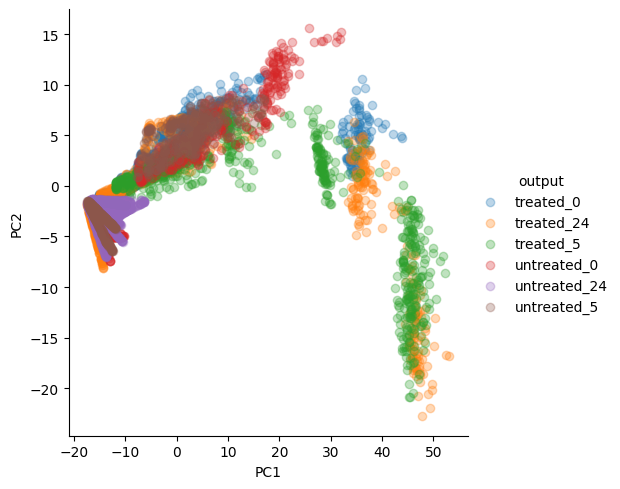

In [10]:
# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['output']=treatment_time
pca_df['groups']=groups
pca_df['date'] = date
import seaborn as sns
sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='output', fit_reg=False, scatter_kws={'alpha':0.3} )

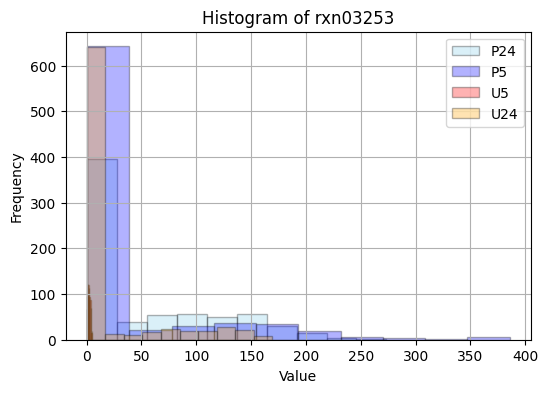

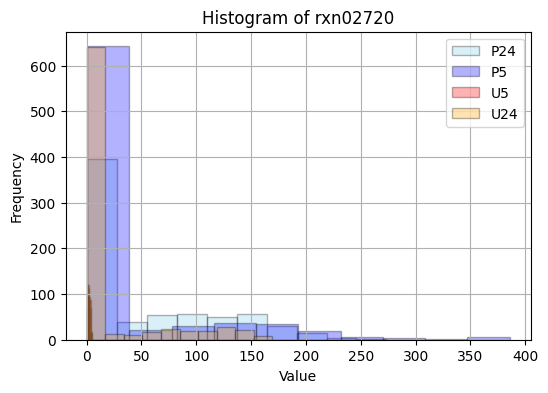

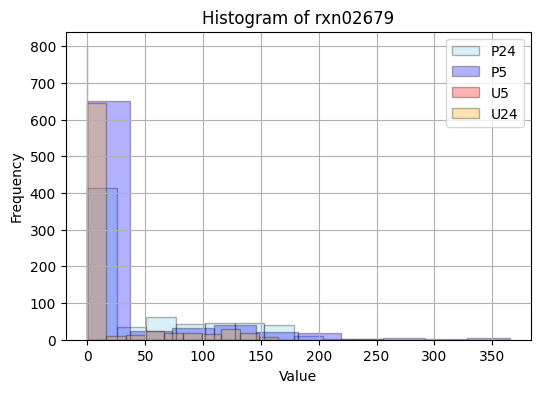

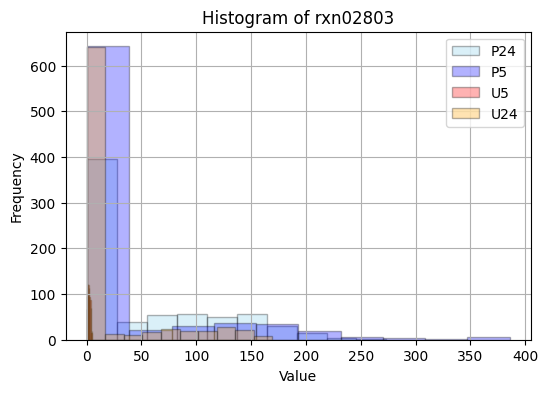

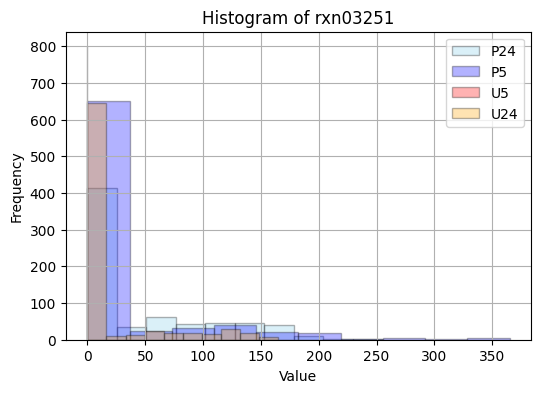

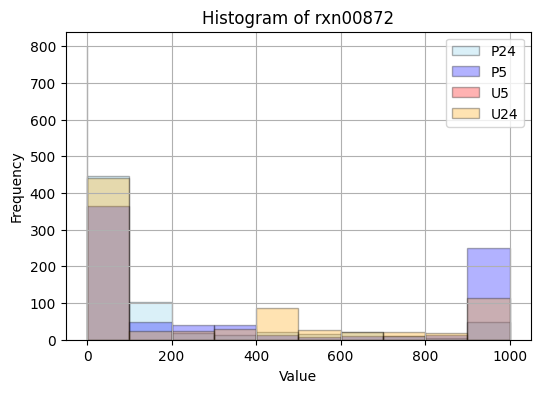

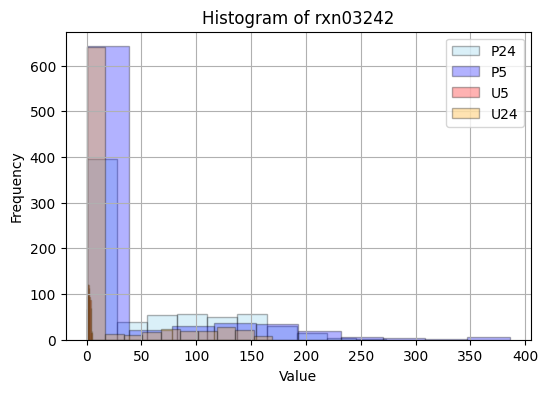

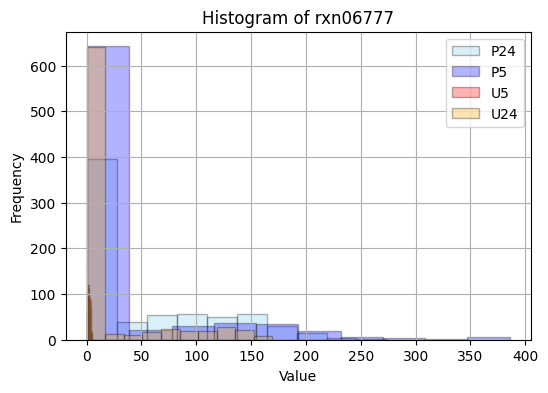

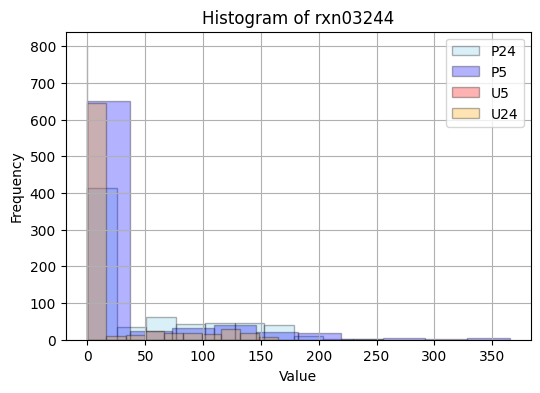

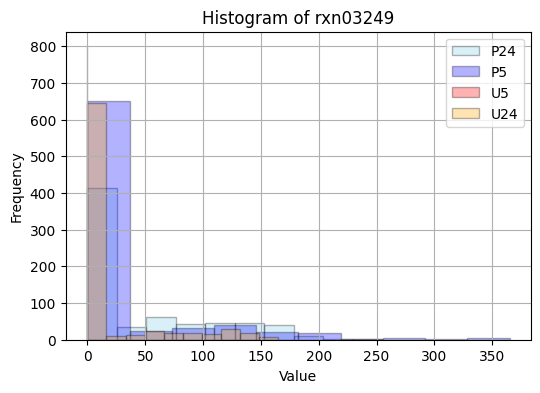

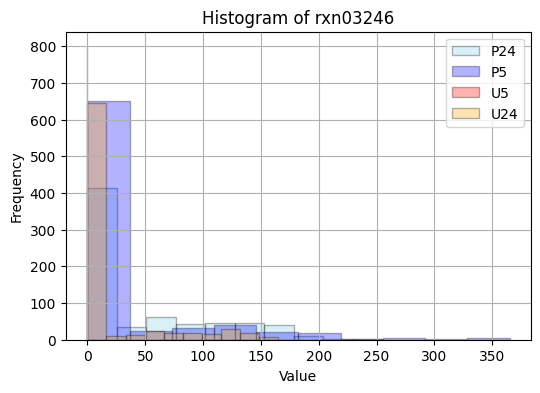

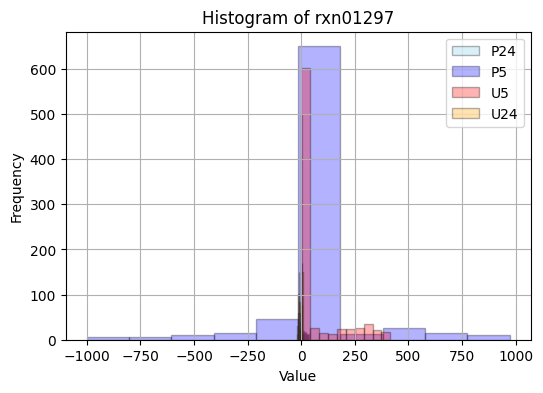

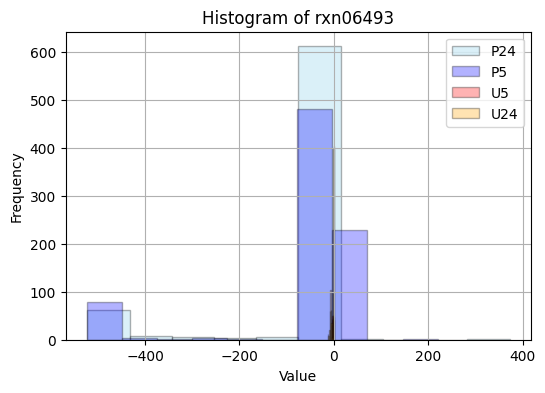

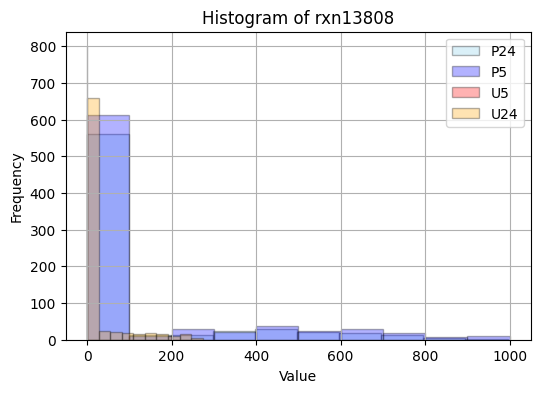

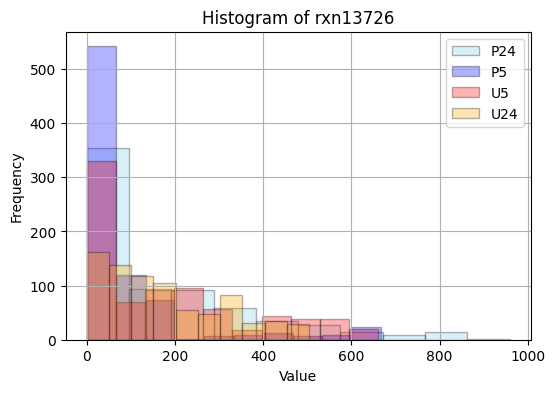

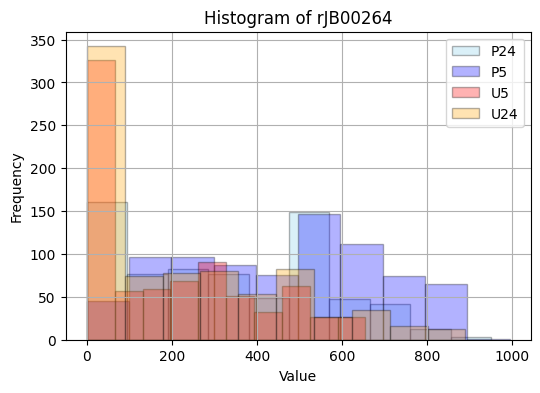

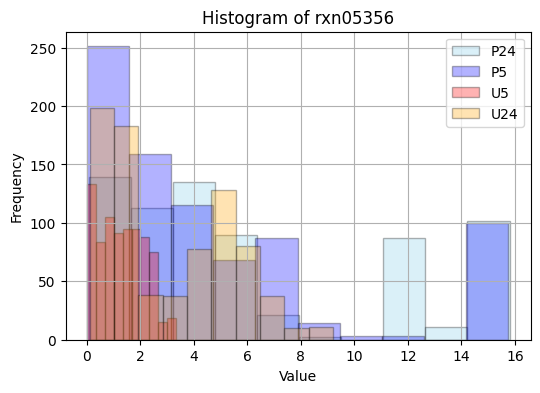

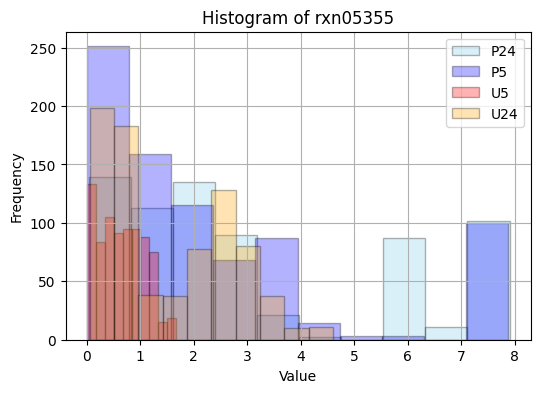

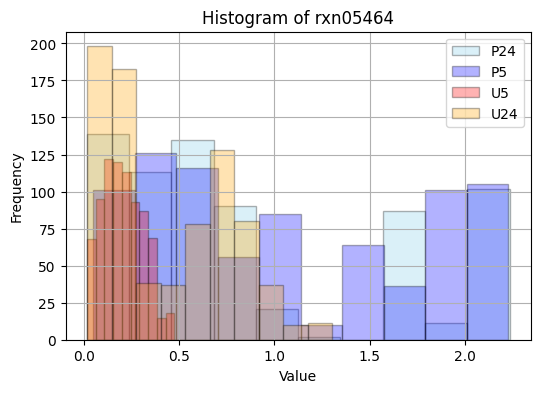

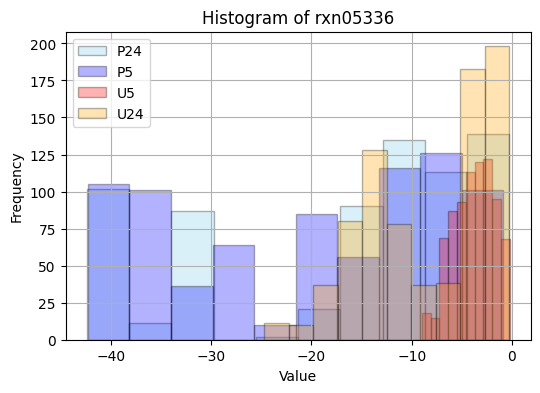

In [75]:
combined_df['output']=treatment_time
for column in combined_df.columns[0:20]:
    plt.figure(figsize=(6, 4))
    plt.hist(combined_df.loc[combined_df.output=='treated_24',[column]], bins=10, color='skyblue', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df.loc[combined_df.output=='treated_5',[column]], bins=10, color='blue', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df.loc[combined_df.output=='untreated_24',[column]], bins=10, color='red', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df.loc[combined_df.output=='untreated_5',[column]], bins=10, color='orange', edgecolor='black', alpha=0.3, stacked=True)
    plt.legend(['P24','P5','U5','U24'])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## gene essentiality

In [13]:
import os
import pandas as pd
from collections import defaultdict, Counter
import re

# Root directory containing the folders
root_dir = r"C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/BIOMASS_open"

# Dictionary to store counts grouped by (condition, number)
gene_counts = defaultdict(Counter)

# Regex pattern to extract "treated"/"untreated" and the number
pattern = re.compile(r"^(treated|untreated)_(\d+)")

# Traverse directories
for foldername in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, foldername)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    # Match folder name pattern
    match = pattern.match(foldername)
    if not match:
        continue

    condition, number = match.groups()  # Extract condition and number

    # Check for essentialgenes.txt file
    essential_genes_path = os.path.join(folder_path, "essentialgenes.txt")
    if not os.path.exists(essential_genes_path):
        continue

    # Read essentialgenes.txt
    with open(essential_genes_path, 'r') as file:
        genes = file.read().splitlines()

    # Update gene counts grouped by (condition, number)
    gene_counts[(condition, number)].update(genes)

# Convert dictionary to DataFrame
data_list = []
for (condition, number), counter in gene_counts.items():
    for gene, count in counter.items():
        data_list.append([gene, condition, number, count])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=["Gene", "Condition", "Number", "Count"])

# Filter data for treated_24 and untreated_24
treated_24 = df[(df["Condition"] == "treated") & (df["Number"] == "24")]
untreated_24 = df[(df["Condition"] == "untreated") & (df["Number"] == "24")]

# Sort the treated_24 genes by count (descending) and untreated_24 by count (ascending)
most_essential_treated = treated_24.sort_values(by="Count", ascending=True)
least_essential_untreated = untreated_24.sort_values(by="Count", ascending=True)
# Pivot table to organize data better
df_pivot = df.pivot_table(index="Gene", columns=["Condition", "Number"], values="Count", fill_value=0)



In [14]:
df_pivot

Condition  treated           untreated          
Number           0   24    5         0   24    5
Gene                                            
PA14_00070     8.0  7.0  8.0       6.0  8.0  8.0
PA14_00280     8.0  7.0  8.0       6.0  8.0  8.0
PA14_00290     8.0  7.0  8.0       6.0  8.0  8.0
PA14_00440     2.0  0.0  1.0       1.0  0.0  1.0
PA14_00450     2.0  0.0  1.0       1.0  0.0  1.0
...            ...  ...  ...       ...  ...  ...
PA14_73280     6.0  5.0  5.0       5.0  8.0  6.0
PA14_73290     6.0  5.0  5.0       5.0  8.0  6.0
PA14_73300     6.0  5.0  5.0       5.0  8.0  6.0
PA14_73310     6.0  5.0  5.0       5.0  8.0  6.0
PA14_73320     6.0  5.0  5.0       5.0  8.0  6.0

[330 rows x 6 columns]

In [15]:
df_pivot['difference_24'] = df_pivot[('treated', '24')] - df_pivot[('untreated', '24')]

# Sort in descending order
df_pivot = df_pivot.sort_values(by='difference_24', ascending=False)

# View the result
print(df_pivot[['difference_24']])

Condition  difference_24
Number                  
Gene                    
PA14_05840           6.0
PA14_23250           5.0
PA14_42740           5.0
PA14_25210           5.0
PA14_42730           5.0
...                  ...
PA14_44050          -6.0
PA14_52870          -6.0
PA14_60700          -7.0
PA14_44010          -7.0
PA14_24640          -7.0

[330 rows x 1 columns]


# ATP models

In [17]:
os.chdir(r'C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/ATP_open/riptide_results_ATP')

In [18]:
combined_df_ATP=pd.DataFrame()
treatment_time = []
group=1
groups=[]
date=[]
parent_dir = r"C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/ATP_open/riptide_results_ATP"
folders = glob.glob(os.path.join(parent_dir, "*17D*"))

for filepath in folders:
    current_df=pd.read_csv(filepath+"\\flux_samples.tsv",sep='\t')
    sampled_df=current_df.sample(100, replace=False)
    combined_df_ATP = pd.concat([combined_df_ATP,sampled_df], axis=0, ignore_index=True)

    #make the output vector
    filename = filepath.split('ATP\\')[1]
    treatment=filename.split('_')[0]
    time = filename.split('_')[1][:-1]
    batch = filename.split('_')[2]
    for i in range(100):
        treatment_time.append(treatment + '_' + time)
        groups.append(group)
        date.append(batch)
    group=group+1  #keep all flux samples from the same model in the same group
    
combined_df_ATP = combined_df_ATP.drop(combined_df_ATP.columns[0],axis=1)
combined_df_ATP = combined_df_ATP.fillna(0).astype(float)
df_ATP = copy.deepcopy(combined_df_ATP)
df_ATP['output'] = treatment_time

## PCA


In [20]:
# Data preprocessing
scaler = StandardScaler()
df_standardized = scaler.fit_transform(combined_df_ATP)

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_standardized)

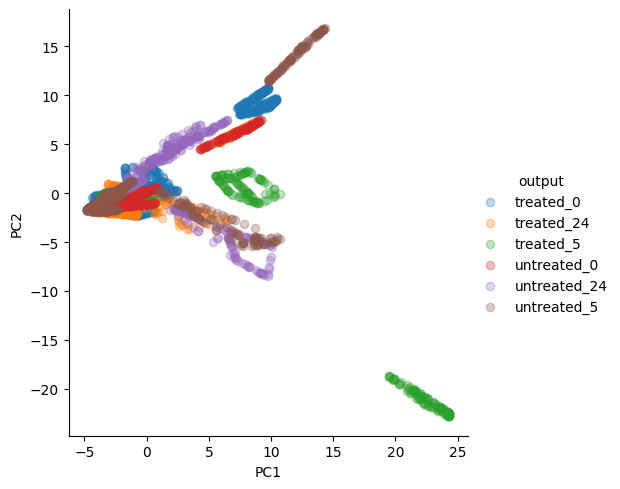

In [21]:
# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['output']=treatment_time
pca_df['groups']=groups
pca_df['date'] = date
import seaborn as sns
sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='output', fit_reg=False, scatter_kws={'alpha':0.3} )

C:\Users\jmf7ak\AppData\Local\Temp\ipykernel_24632\3522065360.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df_ATP['output']=treatment_time


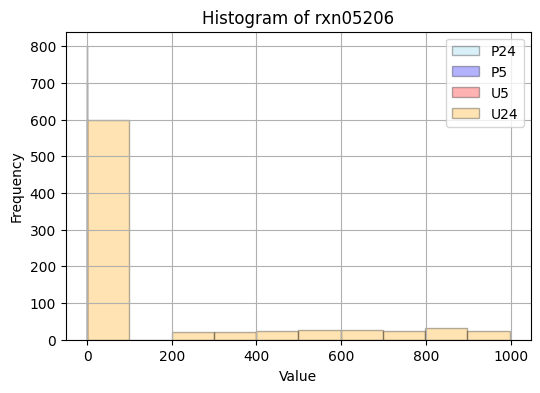

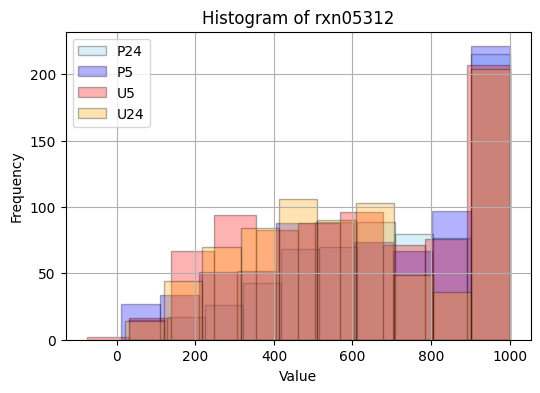

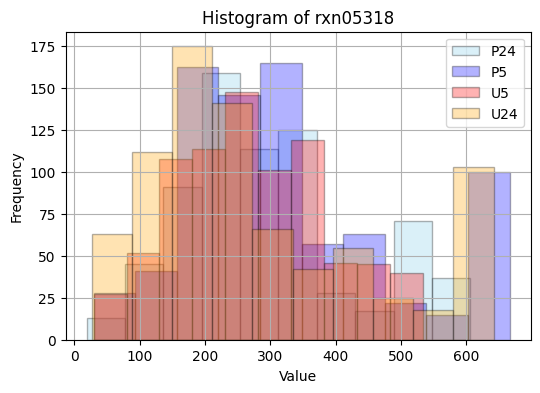

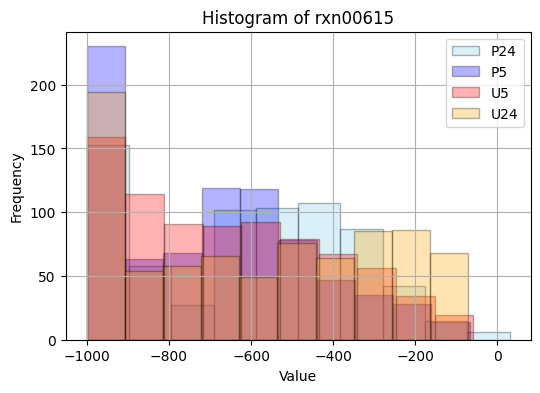

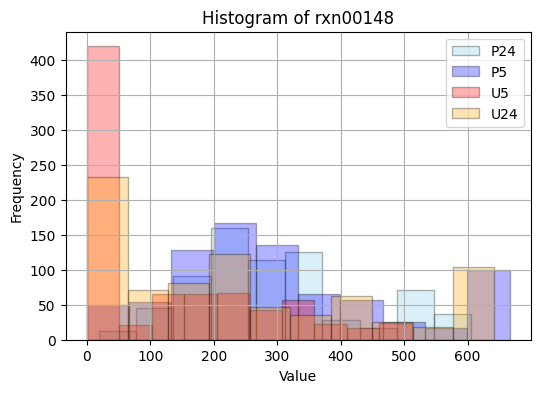

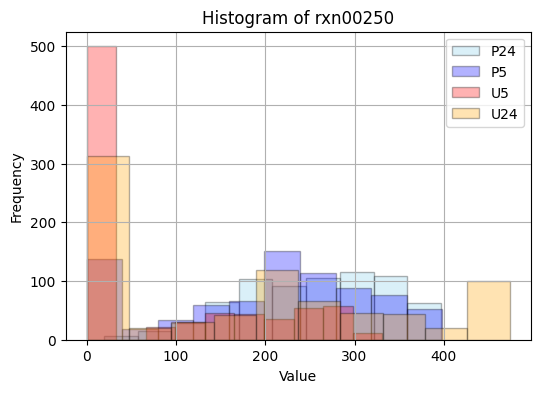

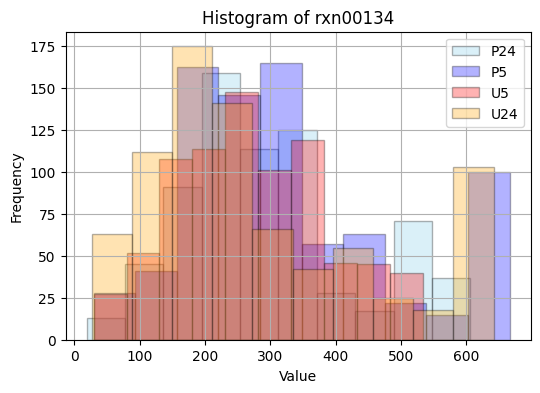

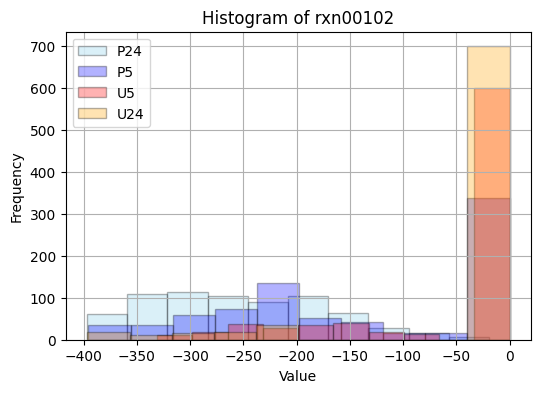

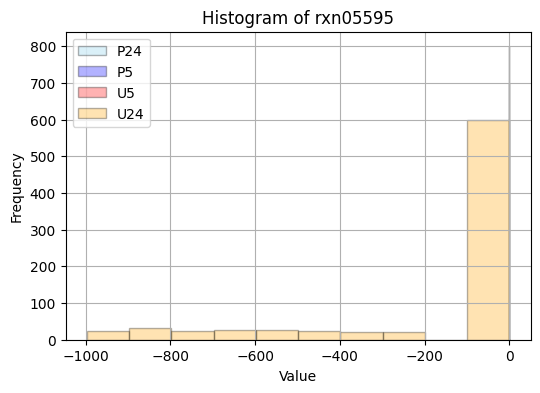

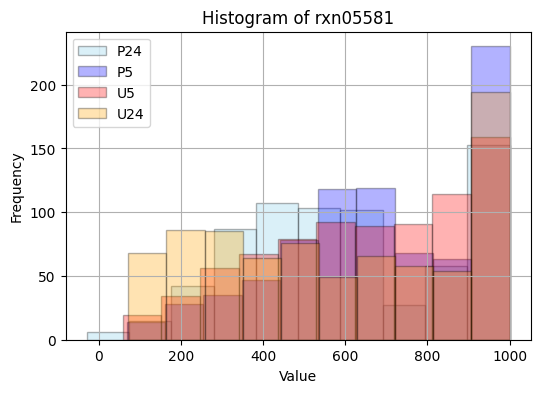

In [22]:
combined_df_ATP['output']=treatment_time
for column in combined_df_ATP.columns[0:10]:
    plt.figure(figsize=(6, 4))
    plt.hist(combined_df_ATP.loc[combined_df_ATP.output=='treated_24',[column]], bins=10, color='skyblue', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df_ATP.loc[combined_df_ATP.output=='treated_5',[column]], bins=10, color='blue', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df_ATP.loc[combined_df_ATP.output=='untreated_24',[column]], bins=10, color='red', edgecolor='black', alpha=0.3, stacked=True)
    plt.hist(combined_df_ATP.loc[combined_df_ATP.output=='untreated_5',[column]], bins=10, color='orange', edgecolor='black', alpha=0.3, stacked=True)
    plt.legend(['P24','P5','U5','U24'])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## gene essentiality

In [26]:
import os
import pandas as pd
from collections import defaultdict, Counter
import re

# Root directory containing the folders
root_dir = r"C:\Users\jmf7ak\OneDrive - University of Virginia/25_SPRING/PERSISTER/open_exchange_riptide_results/ATP_open"

# Dictionary to store counts grouped by (condition, number)
gene_counts = defaultdict(Counter)

# Regex pattern to extract "treated"/"untreated" and the number
pattern = re.compile(r"^(treated|untreated)_(\d+)")

# Traverse directories
for foldername in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, foldername)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    # Match folder name pattern
    match = pattern.match(foldername)
    if not match:
        continue

    condition, number = match.groups()  # Extract condition and number

    # Check for essentialgenes.txt file
    essential_genes_path = os.path.join(folder_path, "essentialgenes.txt")
    if not os.path.exists(essential_genes_path):
        continue

    # Read essentialgenes.txt
    with open(essential_genes_path, 'r') as file:
        genes = file.read().splitlines()

    # Update gene counts grouped by (condition, number)
    gene_counts[(condition, number)].update(genes)

# Convert dictionary to DataFrame
data_list = []
for (condition, number), counter in gene_counts.items():
    for gene, count in counter.items():
        data_list.append([gene, condition, number, count])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=["Gene", "Condition", "Number", "Count"])

# Filter data for treated_24 and untreated_24
treated_24 = df[(df["Condition"] == "treated") & (df["Number"] == "24")]
untreated_24 = df[(df["Condition"] == "untreated") & (df["Number"] == "24")]

# Sort the treated_24 genes by count (descending) and untreated_24 by count (ascending)
most_essential_treated = treated_24.sort_values(by="Count", ascending=True)
least_essential_untreated = untreated_24.sort_values(by="Count", ascending=True)
# Pivot table to organize data better
df_pivot_ATP = df.pivot_table(index="Gene", columns=["Condition", "Number"], values="Count", fill_value=0)



In [27]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', 20)  # Show all columns
pd.set_option('display.width', 20)  # Prevent line truncation
pd.set_option('display.max_colwidth', None)  # Prevent truncation of column content


In [29]:
df_pivot_ATP

Condition  treated  \
Number           0   
Gene                 
PA14_00070     8.0   
PA14_00280     8.0   
PA14_00290     8.0   
PA14_00440     2.0   
PA14_00450     2.0   
PA14_01760     2.0   
PA14_01830     0.0   
PA14_02450     3.0   
PA14_02470     3.0   
PA14_03430     1.0   
PA14_03900     2.0   
PA14_04210     8.0   
PA14_04310     6.0   
PA14_04480     8.0   
PA14_04580     8.0   
PA14_04630     1.0   
PA14_05220     1.0   
PA14_05230     1.0   
PA14_05590     7.0   
PA14_05620     8.0   
PA14_05690     2.0   
PA14_05840     5.0   
PA14_05870     4.0   
PA14_06670     2.0   
PA14_06700     2.0   
PA14_06720     2.0   
PA14_06750     2.0   
PA14_06810     2.0   
PA14_06830     2.0   
PA14_07090     8.0   
PA14_07130     8.0   
PA14_07190     1.0   
PA14_07230     2.0   
PA14_07580     8.0   
PA14_07590     8.0   
PA14_07910     7.0   
PA14_08350     2.0   
PA14_08360     2.0   
PA14_08400     8.0   
PA14_08480     4.0   
PA14_10230     0.0   
PA14_10240     0.0   
PA14_10250     0.0   
PA14_10260     0.0   
PA14_11470     8.0   
PA14_11550     8.0   
PA14_11560     8.0   
PA14_11690     2.0   
PA14_12060     8.0   
PA14_12490     3.0   
PA14_13430     4.0   
PA14_14820     8.0   
PA14_14880     8.0   
PA14_15310     8.0   
PA14_15340     8.0   
PA14_15780     1.0   
PA14_15790     1.0   
PA14_15820     1.0   
PA14_16690    11.0   
PA14_16700    12.0   
PA14_16950     8.0   
PA14_17030     8.0   
PA14_17080     8.0   
PA14_17120     8.0   
PA14_17130     8.0   
PA14_17180     8.0   
PA14_17190     8.0   
PA14_17210     8.0   
PA14_17220     8.0   
PA14_17270     8.0   
PA14_17290     8.0   
PA14_17310     8.0   
PA14_17320     2.0   
PA14_17340     8.0   
PA14_17420     8.0   
PA14_17980    11.0   
PA14_18250     6.0   
PA14_18260     6.0   
PA14_18275     6.0   
PA14_18410     4.0   
PA14_18430     4.0   
PA14_18450     4.0   
PA14_18480     4.0   
PA14_18500     4.0   
PA14_18510     4.0   
PA14_18520     4.0   
PA14_18550     4.0   
PA14_18565     4.0   
PA14_18580     4.0   
PA14_19100     7.0   
PA14_19870     1.0   
PA14_19900     8.0   
PA14_19910     8.0   
PA14_20200     2.0   
PA14_20560     0.0   
PA14_20890     8.0   
PA14_20950     8.0   
PA14_21410     8.0   
PA14_22050     8.0   
PA14_22890     1.0   
PA14_22910     0.0   
PA14_22990     3.0   
PA14_23000     3.0   
PA14_23010     3.0   
PA14_23080     0.0   
PA14_23160     6.0   
PA14_23220     8.0   
PA14_23250     3.0   
PA14_23310     8.0   
PA14_23320     8.0   
PA14_23560     8.0   
PA14_23800     8.0   
PA14_23850     2.0   
PA14_23860     8.0   
PA14_23880     8.0   
PA14_24445     3.0   
PA14_24640     0.0   
PA14_25210     3.0   
PA14_25390     1.0   
PA14_25510     8.0   
PA14_25530     8.0   
PA14_25550     8.0   
PA14_25640     8.0   
PA14_25650     8.0   
PA14_25660     8.0   
PA14_25710     8.0   
PA14_27500     5.0   
PA14_27960     7.0   
PA14_28170     5.0   
PA14_29850    10.0   
PA14_29860    10.0   
PA14_29880    10.0   
PA14_29890    10.0   
PA14_29900    10.0   
PA14_29920    10.0   
PA14_29930    10.0   
PA14_29940    10.0   
PA14_29970    10.0   
PA14_29980    10.0   
PA14_29990    10.0   
PA14_30010    10.0   
PA14_30020    10.0   
PA14_30630     2.0   
PA14_30670     8.0   
PA14_32270     3.0   
PA14_34050     1.0   
PA14_34260     1.0   
PA14_34270     1.0   
PA14_34280     1.0   
PA14_34630     0.0   
PA14_34640     0.0   
PA14_35460     0.0   
PA14_35530     1.0   
PA14_36570    10.0   
PA14_36840     2.0   
PA14_37950     5.0   
PA14_38110     8.0   
PA14_38130     8.0   
PA14_38350     8.0   
PA14_38610     0.0   
PA14_38660     0.0   
PA14_38690     0.0   
PA14_39050     8.0   
PA14_39190     8.0   
PA14_39280    15.0   
PA14_39690     1.0   
PA14_40670     7.0   
PA14_41010     6.0   
PA14_41170     8.0   
PA14_41350     0.0   
PA14_41400     8.0   
PA14_41530     1.0   
PA14_41540     1.0   
PA14_41820     8.0   
PA14_42090     1.0   
PA14_42720     3.0   
PA14_42730     3.0   
PA14_42740     3.0   
PA14_42760     8.0

In [30]:
df_pivot_ATP['difference_24'] = df_pivot_ATP[('treated', '24')] - df_pivot_ATP[('untreated', '24')]

# Sort in descending order
df_pivot_ATP = df_pivot_ATP.sort_values(by='difference_24', ascending=False)

# View the result
print(df_pivot_ATP[['difference_24']])

Condition  difference_24
Number                  
Gene                    
PA14_05840           7.0
PA14_42740           5.0
PA14_42730           5.0
PA14_61680           5.0
PA14_42720           5.0
PA14_23250           5.0
PA14_25210           5.0
PA14_06830           4.0
PA14_06720           4.0
PA14_06700           4.0
PA14_06670           4.0
PA14_06810           4.0
PA14_06750           4.0
PA14_20200           4.0
PA14_65770           3.0
PA14_54640           3.0
PA14_28170           3.0
PA14_18580           3.0
PA14_18565           3.0
PA14_18550           3.0
PA14_18520           3.0
PA14_18510           3.0
PA14_18500           3.0
PA14_18480           3.0
PA14_18450           3.0
PA14_18430           3.0
PA14_18410           3.0
PA14_70950           3.0
PA14_03900           3.0
PA14_12490           2.0
PA14_52900           2.0
PA14_52850           2.0
PA14_52840           2.0
PA14_52820           2.0
PA14_04630           2.0
PA14_68770           2.0
PA14_62130           2.0


In [31]:
sum_essential =df_pivot_ATP[['difference_24']] + df_pivot[['difference_24']]
print(sum_essential.sort_values(by='difference_24', ascending=False))

Condition  difference_24
Number                  
Gene                    
PA14_05840          13.0
PA14_23250          10.0
PA14_42730          10.0
PA14_42720          10.0
PA14_25210          10.0
PA14_42740          10.0
PA14_61680          10.0
PA14_20200           8.0
PA14_06670           8.0
PA14_06720           8.0
PA14_06830           8.0
PA14_06750           8.0
PA14_06810           8.0
PA14_06700           8.0
PA14_18580           6.0
PA14_18500           6.0
PA14_18520           6.0
PA14_18480           6.0
PA14_18450           6.0
PA14_18510           6.0
PA14_18565           6.0
PA14_70950           6.0
PA14_03900           6.0
PA14_65770           6.0
PA14_18550           6.0
PA14_18430           6.0
PA14_18410           6.0
PA14_54640           6.0
PA14_28170           5.0
PA14_23080           4.0
PA14_12490           4.0
PA14_62130           4.0
PA14_43970           4.0
PA14_42090           4.0
PA14_62150           4.0
PA14_05230           4.0
PA14_68770           4.0


## mann whitney on flux sampling data

In [142]:
# open model to look at rxns
import cobra
os.chdir(r'C:\Users\jmf7ak\OneDrive - University of Virginia/23_FALL/Persister_paper_again')
# Read the SBML model from the XML file
model = cobra.io.read_sbml_model("iPau21.xml")

In [141]:
#biomass
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Group labels and flux data
group_vec = df_biomass["output"]
flux_data = df_biomass.drop(columns=["output"])

results = []

# Loop through each reaction
for reaction in flux_data.columns:
    group1 = flux_data.loc[group_vec == "treated_24", reaction]
    group2 = flux_data.loc[group_vec == "untreated_24", reaction]

    # If either group is all NaNs or has no variability, skip
    if group1.dropna().nunique() == 0 or group2.dropna().nunique() == 0:
        p = np.nan
    else:
        try:
            # Mann-Whitney U test (non-parametric)
            stat, p = mannwhitneyu(group1, group2, alternative='greater')
        except ValueError:
            p = np.nan

    results.append({
        "reaction": reaction,
        "p_value": p
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Drop NaN p-values
results_df_clean = results_df.dropna()

# Adjust for multiple testing
results_df_clean["adj_p_value"] = multipletests(results_df_clean["p_value"], method="fdr_bh")[1]

# Merge to get full list with adjusted p-values
results_df = results_df.merge(results_df_clean, on="reaction", how="left")

# Filter for significant results
significant = results_df[results_df["adj_p_value"] < 0.05]

# Show top hits
significant.sort_values("adj_p_value").head()

,reaction,p_value_x,p_value_y,adj_p_value
383,EX_cpd00379_e,1.321141e-231,1.321141e-231,8.191077e-229
388,rxn00178,2.154427e-230,2.154427e-230,6.678724e-228
359,EX_cpd00528_e,1.102209e-221,1.102209e-221,1.708424e-219
209,rxn13864,1.101222e-221,1.101222e-221,1.708424e-219
75,rxn05202,2.703690e-218,2.703690e-218,3.352575e-216


In [143]:
top_reactions = significant.sort_values("adj_p_value")['reaction'][0:10]  # replace with actual IDs

# For each reaction, get associated genes
for rxn_id in top_reactions:
    reaction = model.reactions.get_by_id(rxn_id)
    gene_ids = [gene.id for gene in reaction.genes]
    print(f"Reaction ID:   {reaction.id}")
    print(f"Reaction Name: {reaction.name}")
    print(f"Genes:         {gene_ids}")
    print(f"Gene Rule:     {reaction.gene_reaction_rule}")
    print("-" * 40)

Reaction ID:   EX_cpd00379_e
Reaction Name: EX Glutarate
Genes:         []
Gene Rule:     
----------------------------------------
Reaction ID:   rxn00178
Reaction Name: Acetyl-CoA:acetyl-CoA C-acetyltransferase
Genes:         ['PA14_63250', 'PA14_31530', 'PA14_42090', 'PA14_13090', 'PA14_17880', 'PA14_38630']
Gene Rule:     PA14_13090 or PA14_17880 or PA14_31530 or PA14_38630 or PA14_42090 or PA14_63250
----------------------------------------
Reaction ID:   EX_cpd00528_e
Reaction Name: EX nitrogen e
Genes:         []
Gene Rule:     
----------------------------------------
Reaction ID:   rxn13864
Reaction Name: nitrous-oxide reductase precursor
Genes:         ['PA14_20200']
Gene Rule:     PA14_20200
----------------------------------------
Reaction ID:   rxn05202
Reaction Name: Xanthine transport in via proton symport
Genes:         ['PA14_26050', 'PA14_06230', 'PA14_02070', 'PA14_46100', 'PA14_44800', 'PA14_05700', 'PA14_44950', 'PA14_67340', 'PA14_62440', 'PA14_05790', 'PA14_04610

In [147]:
#ATP
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Group labels and flux data
group_vec = df_ATP["output"]
flux_data = df_ATP.drop(columns=["output"])

results = []

# Loop through each reaction
for reaction in flux_data.columns:
    group1 = flux_data.loc[group_vec == "treated_24", reaction]
    group2 = flux_data.loc[group_vec == "untreated_24", reaction]

    # If either group is all NaNs or has no variability, skip
    if group1.dropna().nunique() == 0 or group2.dropna().nunique() == 0:
        p = np.nan
    else:
        try:
            # Mann-Whitney U test (non-parametric)
            stat, p = mannwhitneyu(group1, group2, alternative='greater')
        except ValueError:
            p = np.nan

    results.append({
        "reaction": reaction,
        "p_value_ATP": p
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Drop NaN p-values
results_df_clean = results_df.dropna()

# Adjust for multiple testing
results_df_clean["adj_p_value_ATP"] = multipletests(results_df_clean["p_value_ATP"], method="fdr_bh")[1]

# Merge to get full list with adjusted p-values
results_df = results_df.merge(results_df_clean, on="reaction", how="left")

# Filter for significant results
significant_ATP = results_df[results_df["adj_p_value_ATP"] < 0.05]

# Show top hits
significant_ATP.sort_values("adj_p_value_ATP").head()

,reaction,p_value_ATP_x,p_value_ATP_y,adj_p_value_ATP
5,rxn00250,1.762227e-146,1.762227e-146,2.960541e-144
11,rxn00251,2.855900e-95,2.855900e-95,2.398956e-93
4,rxn00148,1.765386e-92,1.765386e-92,9.886164e-91
138,rJB00238,7.094222e-70,7.094222e-70,2.979573e-68
144,rxn01636,2.467108e-64,2.467108e-64,6.907903e-63


In [148]:
top_reactions = significant_ATP.sort_values("adj_p_value_ATP")['reaction'][0:10]  # replace with actual IDs

# For each reaction, get associated genes
for rxn_id in top_reactions:
    reaction = model.reactions.get_by_id(rxn_id)
    gene_ids = [gene.id for gene in reaction.genes]
    print(f"Reaction ID:   {reaction.id}")
    print(f"Reaction Name: {reaction.name}")
    print(f"Genes:         {gene_ids}")
    print(f"Gene Rule:     {reaction.gene_reaction_rule}")
    print("-" * 40)

Reaction ID:   rxn00250
Reaction Name: Pyruvate carboxylase
Genes:         ['PA14_46320']
Gene Rule:     PA14_46320
----------------------------------------
Reaction ID:   rxn00251
Reaction Name: Phosphoenolpyruvate carboxylase
Genes:         ['PA14_16690']
Gene Rule:     PA14_16690
----------------------------------------
Reaction ID:   rxn00148
Reaction Name: Pyruvate kinase
Genes:         ['PA14_45050', 'PA14_56240']
Gene Rule:     PA14_56240 or PA14_45050
----------------------------------------
Reaction ID:   rJB00238
Reaction Name: Sodium-succinate symporter (dctA and dctPQM)
Genes:         ['PA14_52820', 'PA14_68260', 'PA14_68280', 'PA14_68290', 'PA14_52840', 'PA14_52810']
Gene Rule:     (PA14_52840 and PA14_52820 and PA14_52810) or (PA14_68290 and PA14_68280 and PA14_68260)
----------------------------------------
Reaction ID:   rxn01636
Reaction Name: ornithine transacetylase
Genes:         ['PA14_57210']
Gene Rule:     PA14_57210
----------------------------------------
React

# Random Forest

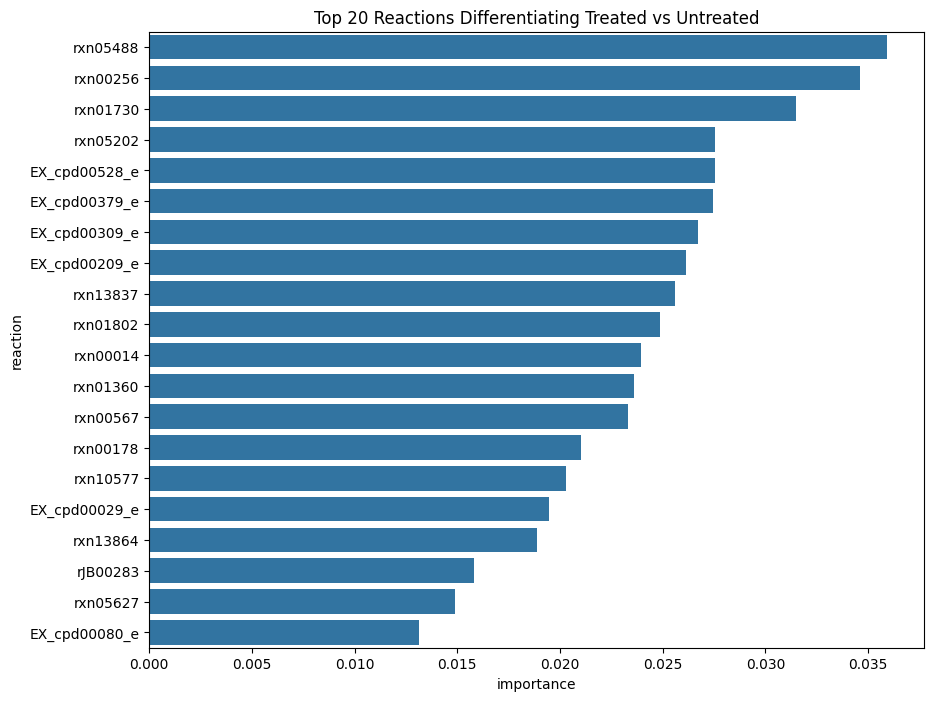

Mean accuracy: 0.92 ± 0.10


In [155]:
# Group labels and flux data
df_filtered = df_biomass[df_biomass['output'].isin(['untreated_24', 'treated_24'])]
X = df_filtered.drop(columns=['output'])   # all flux columns
y = df_filtered['output'].map({
    'untreated_24': 0,
    'untreated_5': 0,
    'treated_24': 1,
    'treated_5': 1
})
# Initialize random forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)

# Train
rf.fit(X, y)

importances = rf.feature_importances_

# Map importance to reactions
importance_df = pd.DataFrame({
    'reaction': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='reaction', data=importance_df.head(20))
plt.title('Top 20 Reactions Differentiating Treated vs Untreated')
plt.show()

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5)
print(f"Mean accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

In [159]:
# 1. Select top 10 reactions
top_reactions = importance_df['reaction'].head(20
                                ).tolist()

# 2. Get associated genes from the model
for rxn_id in top_reactions:
    try:
        reaction = model.reactions.get_by_id(rxn_id)
        gene_ids = [gene.id for gene in reaction.genes]

        print(f"Reaction ID:   {reaction.id}")
        print(f"Reaction Name: {reaction.name}")
        print(f"Genes:         {gene_ids}")
        print(f"Gene Rule:     {reaction.gene_reaction_rule}")
        print("-" * 40)
    except KeyError:
        print(f"Reaction {rxn_id} not found in the model!")
        print("-" * 40)

Reaction ID:   rxn05488
Reaction Name: Acetate reversible transport via proton symport
Genes:         ['PA14_22350', 'PA14_35920']
Gene Rule:     PA14_22350 or PA14_35920
----------------------------------------
Reaction ID:   rxn00256
Reaction Name: Citrate synthase
Genes:         ['PA14_44070', 'PA14_53950']
Gene Rule:     PA14_53950 or PA14_44070
----------------------------------------
Reaction ID:   rxn01730
Reaction Name: Glutaryl-CoA synthetase
Genes:         []
Gene Rule:     
----------------------------------------
Reaction ID:   rxn05202
Reaction Name: Xanthine transport in via proton symport
Genes:         ['PA14_26050', 'PA14_06230', 'PA14_02070', 'PA14_46100', 'PA14_44800', 'PA14_05700', 'PA14_44950', 'PA14_67340', 'PA14_62440', 'PA14_05790', 'PA14_04610', 'PA14_61480']
Gene Rule:     PA14_05700 or PA14_06230 or PA14_67340 or PA14_44800 or PA14_46100 or PA14_02070 or PA14_04610 or PA14_26050 or PA14_05790 or PA14_61480 or PA14_44950 or PA14_62440
-------------------------

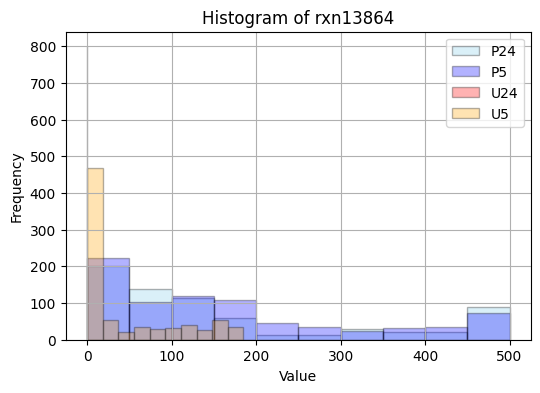

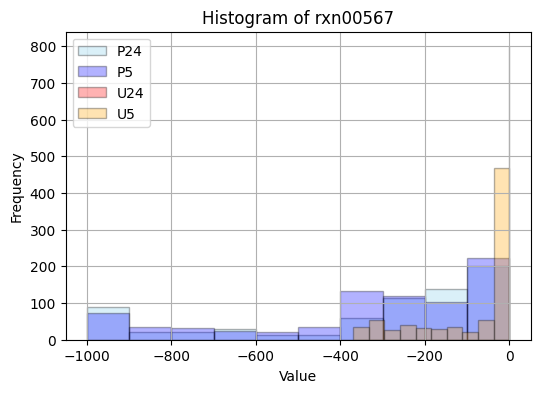

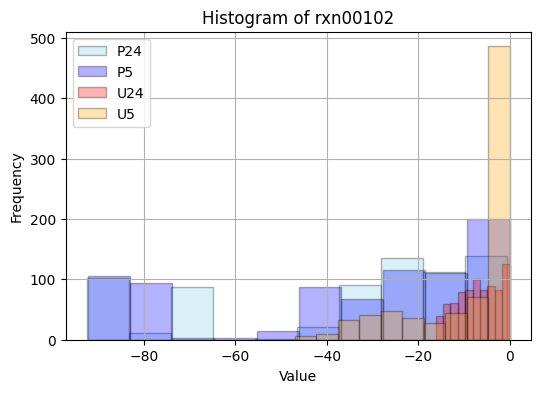

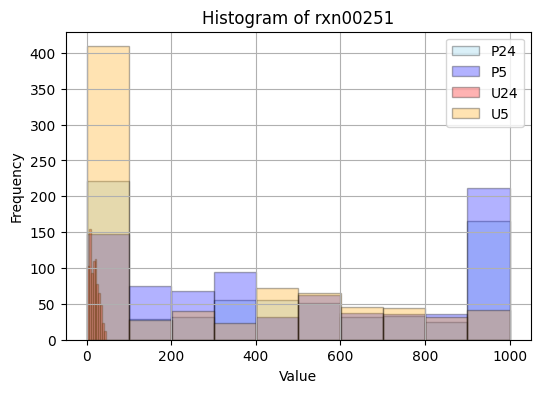

KeyError: 'rxn00097'

<Figure size 600x400 with 0 Axes>

In [119]:
combined_df['output']=treatment_time
columns_to_plot = ['rxn13864', 'rxn00567', 'rxn00102', 'rxn00251', 'rxn00097']

for column in columns_to_plot:
    plt.figure(figsize=(6, 4))

    plt.hist(combined_df.loc[combined_df.output=='treated_24', column], bins=10, color='skyblue', edgecolor='black', alpha=0.3, label='P24')
    plt.hist(combined_df.loc[combined_df.output=='treated_5', column], bins=10, color='blue', edgecolor='black', alpha=0.3, label='P5')
    plt.hist(combined_df.loc[combined_df.output=='untreated_24', column], bins=10, color='red', edgecolor='black', alpha=0.3, label='U24')
    plt.hist(combined_df.loc[combined_df.output=='untreated_5', column], bins=10, color='orange', edgecolor='black', alpha=0.3, label='U5')

    plt.legend()
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [111]:
combined_df.columns

Index(['rxn03253',
       'rxn02720',
       'rxn02679',
       'rxn02803',
       'rxn03251',
       'rxn00872',
       'rxn03242',
       'rxn06777',
       'rxn03244',
       'rxn03249',
       ...
       'rxn00691',
       'rxn01211',
       'rxn01045',
       'rxn00904',
       'rxn13889',
       'rxn06043',
       'rxn00935',
       'rxn13681',
       'rxn10474',
       'output'],
      dtype='object', length=621)